In [1]:
# Importation des programmathèques nécessaires
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from ydata_profiling import ProfileReport
import seaborn as sns
import calendar
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# === FONCTIONS ===

# Diagnostic sur les données. Le fichier en entrée de la fonction contiendra le rapport.
def diagnostic(donnees, titre, fichier):
    rapport = ProfileReport(donnees, title=titre, explorative=True, correlations={"auto": {"calculate": False}})
    rapport.to_file(fichier)
    print("\nConsultez le fichier \"", fichier, "\" afin de visualiser le diagnostic.\n")

# Duplique les données d'un groupby en ne gardant qu'une catégorie par entrée.
# Affiche aussi la différence avant / après
def compte_avec_recoupages(donnees_entrantes):
    # Sépare les données en plusieurs colonnes
    donnees_separees = donnees_entrantes.str.split(pat=", ", expand=True)
    print("======= Étendage des données ========\n")    
    print(donnees_separees)

    # On a obtenu un maximum de x genre par entrée.
    nb_colonnes_add = donnees_separees.shape[1] -1 # Nombre de colonnes additionnelles
    # Il nous suffit de comptabiliser par chacune des colonnes et des les aditionner
    # On prend soin de remplacer les chaînes vides par NaN (ex: ", genre2"  commence par une virgule et crée ainsi une chaîne vide au début)
    # Lors de l'addition des colonnes, les genres non comptabilisés dans une colonne donnée seront replacées par 0.
    retour = donnees_separees.replace("", np.nan).groupby(0)[0].count()
    for index in range(1,nb_colonnes_add): # Commence à 1 car on n'a pas besoin d'ajouter 0 à 0...
        retour = retour.add(donnees_separees.replace("", np.nan).groupby(index)[index].count(), fill_value=0)
    retour = retour.astype("int64")
    print("\n======= Recoupage et comptage des données ========\n")
    print(retour)    
    return retour
    
# Affiche les types de données dans un DataFrame.
def affiche_typedonnees(donnees): # On aura besoin de réutiliser.
    print("-----------------Types de données :")
    print(donnees.dtypes)

In [3]:
# === PROGRAMME PRINCIPAL ===
# (Séparé par des ---- afin de conserver, dans le fichier Python, la structure du notebook Jupyter.)

In [4]:
# ------------------------------------------------------------------------------
# Chargement des données
fichier = "netflix_titles.csv"
donnees = pd.read_csv(fichier, encoding='utf-8', encoding_errors='ignore')  # Chargement du fichier csv
print(f"Nombre de lignes : {donnees.shape[0]}; Nombre de colonnes : {donnees.shape[1]}")
print(f"Données chargées depuis le fichier \"{fichier}\".")

Nombre de lignes : 8807; Nombre de colonnes : 12
Données chargées depuis le fichier "netflix_titles.csv".


# 1 - Exploration des données

In [5]:
# ------------------------------------------------------------------------------
# Diagnostics
diagnostic(donnees, "Rapport de pré-nettoyage", "pré-nettoyage.html") # Diagnostic pré-nettoyage
affiche_typedonnees(donnees)
print("-----------------Types de données :")
print(donnees.head()) # Aperçu des données pour guider le nettoyage

/Users/davidndimina/anaconda3/lib/python3.11/site-packages/ydata_profiling/profile_report.py:365: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 18.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


Consultez le fichier " pré-nettoyage.html " afin de visualiser le diagnostic.

-----------------Types de données :
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
-----------------Types de données :
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, 

In [6]:
# ------------------------------------------------------------------------------
# Attribution du type de données exact de chacune des colonnes
donnees = donnees.convert_dtypes()
affiche_typedonnees(donnees)

-----------------Types de données :
show_id         string[python]
type            string[python]
title           string[python]
director        string[python]
cast            string[python]
country         string[python]
date_added      string[python]
release_year             Int64
rating          string[python]
duration        string[python]
listed_in       string[python]
description     string[python]
dtype: object


In [7]:
# ------------------------------------------------------------------------------
# Conversion des valeurs de date en format utile à l'analyse
donnees["date_added"] = pd.to_datetime(donnees["date_added"], format= '%B %d, %Y', errors='coerce')
print(donnees.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water             <NA>   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans             <NA>   
4      s5  TV Show           Kota Factory             <NA>   

                                                cast        country  \
0                                               <NA>  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...           <NA>   
3                                               <NA>           <NA>   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

  date_added  release_year rating   duration  \
0 2021-09-25          2020  PG-13     90 min   
1 2021-09-24          2021  TV-MA  2 Seasons   
2 2021-09-24          2021  TV-MA   1 Season   
3 2021-0

# 2 - Analyses de contenus

In [8]:
# ------------------------------------------------------------------------------
# 2a) Analyse de contenus: types de produit audiovisuel
print(" TYPES DE PRODUITS AUDIOVISUELS \n")
types = donnees.groupby("type")["type"].count()  # regroupement par type
print("====== Aperçu préliminaire =======")
print(types)
# Calcul et affichage des proportions
types_pourcentages = types / donnees.shape[0] * 100 # convertion en pourcentages 
print("\n======== Proportions (%) =========")
print(types_pourcentages.round(2))

# Recoupage des tendances
types_tendances = donnees.groupby(["release_year","type"])["type"].count() # regroupement par année de sortie puis type
types_tendances = types_tendances.unstack().fillna(0).astype("int64")
print("\n========== Tendances par année ========")
print(types_tendances)

 TYPES DE PRODUITS AUDIOVISUELS 

====== Aperçu préliminaire =======
type
Movie      6131
TV Show    2676
Name: type, dtype: int64

======== Proportions (%) =========
type
Movie      69.62
TV Show    30.38
Name: type, dtype: float64

========== Tendances par année ========
type          Movie    TV Show
release_year                  
1925                0        1
1942                2        0
1943                3        0
1944                3        0
1945                3        1
...               ...      ...
2017              767      265
2018              767      380
2019              633      397
2020              517      436
2021              277      315

[74 rows x 2 columns]


In [9]:
# ------------------------------------------------------------------------------
# Étape 2 :  Longueur des produits audiovisuels
# D'après notre rapport d'analyse (HTML), il manque 3 valeurs. On commence par les nettoyer.
donnees_temp = donnees.copy()
donnees_temp = donnees_temp.dropna(subset=["duration"])
# Extraction des entiers de la valeur "duration"
donnees_temp["duration"] = donnees_temp["duration"].str.extract(r"(\d+)").astype(int)
# Sépare les données en films et séries
movies = donnees_temp[(donnees_temp["type"] == "Movie")]
shows = donnees_temp[(donnees_temp["type"] == "TV Show")]
# Affichage des maximum et des minimum
print("Durée minimum des films :", movies["duration"].min(),"minutes")
print("Durée maximum des films :", movies["duration"].max(),"minutes")
print("Nombre de saisons minimum des séries :", shows["duration"].min(), "saison(s)")
print("Nombre de saisons maximum des séries :", shows["duration"].max(), "saison(s)")

Durée minimum des films : 3 minutes
Durée maximum des films : 312 minutes
Nombre de saisons minimum des séries : 1 saison(s)
Nombre de saisons maximum des séries : 17 saison(s)


In [10]:
# ------------------------------------------------------------------------------
# 2b) Analyse de contenus: genres (listed_in)
print(" GENRES \n")
print("======= Apperçu préliminaire ========")
print(donnees.groupby("listed_in")["listed_in"].count())  # regroupement par genre

 GENRES 

======= Apperçu préliminaire ========
listed_in
Action & Adventure                                   128
Action & Adventure, Anime Features                     1
Action & Adventure, Anime Features, Children &...      4
Action & Adventure, Anime Features, Classic Mo...      2
Action & Adventure, Anime Features, Horror Movies      1
                                                    ... 
TV Horror, TV Mysteries, Teen TV Shows                 1
TV Horror, Teen TV Shows                               2
TV Sci-Fi & Fantasy, TV Thrillers                      1
TV Shows                                              16
Thrillers                                             65
Name: listed_in, Length: 514, dtype: int64


In [11]:
# ------------------------------------------------------------------------------
# Souvent plus d'une donnée présente par enregistrement.
genres = compte_avec_recoupages(donnees["listed_in"])
genres = genres.sort_values(ascending=False)

======= Étendage des données ========

                             0                       1                      2
0                Documentaries                    <NA>                   <NA>
1       International TV Shows               TV Dramas           TV Mysteries
2               Crime TV Shows  International TV Shows  TV Action & Adventure
3                   Docuseries              Reality TV                   <NA>
4       International TV Shows       Romantic TV Shows            TV Comedies
...                        ...                     ...                    ...
8802               Cult Movies                  Dramas              Thrillers
8803                  Kids' TV         Korean TV Shows            TV Comedies
8804                  Comedies           Horror Movies                   <NA>
8805  Children & Family Movies                Comedies                   <NA>
8806                    Dramas    International Movies       Music & Musicals

[8807 rows x 3 columns]


In [12]:
# ------------------------------------------------------------------------------
# 2c) Analyse de contenus: répartition géographique
print(" RÉPARTITION GÉOGRAPHIQUE \n")
# Les entrées manquantes seront premièrement marquées "Unkown".
donees_temp = donnees
donees_temp["country"] = donees_temp["country"].fillna("Unknown")
print("======= Apperçu préliminaire ========")
print(donees_temp.groupby("country")["country"].count()) # regroupement par pays

 RÉPARTITION GÉOGRAPHIQUE 

======= Apperçu préliminaire ========
country
, France, Algeria                                     1
, South Korea                                         1
Argentina                                            56
Argentina, Brazil, France, Poland, Germany, De...     1
Argentina, Chile                                      2
                                                     ..
Venezuela                                             1
Venezuela, Colombia                                   1
Vietnam                                               7
West Germany                                          1
Zimbabwe                                              1
Name: country, Length: 749, dtype: int64


In [13]:
# ------------------------------------------------------------------------------
# Souvent plus d'une donnée présente par enregistrement.
pays = compte_avec_recoupages(donees_temp["country"])
pays = pays.sort_values(ascending=False)

======= Étendage des données ========

                 0     1     2     3     4     5     6     7     8     9   \
0     United States  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
1      South Africa  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2           Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
3           Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
4             India  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
8802  United States  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8803        Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8804  United States  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8805  United States  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8806          India  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

        10    11  
0     <NA>  <NA> 

In [14]:
# 2d1) Analyse de contenus: acteurs
print(" ACTEURS \n")
# Les entrées manquantes seront premièrement marquées "Unkown".
donees_temp = donnees
donees_temp["cast"] = donees_temp["cast"].fillna("Unknown")
print("======= Apperçu préliminaire ========")
print(donees_temp.groupby("cast")["cast"].count()) # regroupement par acteur

 ACTEURS 

======= Apperçu préliminaire ========
cast
'Najite Dede, Jude Chukwuka, Taiwo Arimoro, Od...    1
4Minute, B1A4, BtoB, ELSIE, EXID, EXO, Got7, I...    1
50 Cent, Ryan Phillippe, Bruce Willis, Rory Ma...    1
A.J. LoCascio, Sendhil Ramamurthy, Fred Tatasc...    1
A.R. Rahman                                          1
                                                    ..
İbrahim Büyükak, Zeynep Koçak, Gupse Özay, Cen...    1
İbrahim Çelikkol, Belçim Bilgin, Alican Yüceso...    1
Şahin Irmak, İrem Sak, Gonca Vuslateri, Emre K...    1
Şükrü Özyıldız, Aslı Enver, Şenay Gürler, Başa...    1
Ṣọpẹ́ Dìrísù, Wunmi Mosaku, Matt Smith, Malaik...    1
Name: cast, Length: 7693, dtype: int64


In [15]:
# ------------------------------------------------------------------------------
# Souvent plus d'une donnée présente par enregistrement.
acteurs = compte_avec_recoupages(donees_temp["cast"])
print("\n======= Les cinq acteurs les plus fréquents ========")
acteurs_frequents = acteurs.drop(index="Unknown").reset_index(name='count').sort_values(['count'], ascending=False).head(10)
print(acteurs_frequents)
# (P.S.: On remarque que "Jr". a mal été découpé, mais sa relative très faible fréquence ne donne pas lieu à coder spécialement pour rectifier.)

======= Étendage des données ========

                   0                1                  2                 3   \
0             Unknown             <NA>               <NA>              <NA>   
1          Ama Qamata      Khosi Ngema      Gail Mabalane    Thabang Molaba   
2       Sami Bouajila     Tracy Gotoas        Samuel Jouy     Nabiha Akkari   
3             Unknown             <NA>               <NA>              <NA>   
4          Mayur More   Jitendra Kumar         Ranjan Raj         Alam Khan   
...               ...              ...                ...               ...   
8802     Mark Ruffalo  Jake Gyllenhaal  Robert Downey Jr.   Anthony Edwards   
8803          Unknown             <NA>               <NA>              <NA>   
8804  Jesse Eisenberg  Woody Harrelson         Emma Stone   Abigail Breslin   
8805        Tim Allen    Courteney Cox        Chevy Chase         Kate Mara   
8806    Vicky Kaushal  Sarah-Jane Dias    Raaghav Chanana  Manish Chaudhary   

            

In [16]:
# 2d2) Analyse de contenus: réalisateurs
print(" RÉALISATEURS \n")
# Les entrées manquantes seront premièrement marquées "Unkown".
donees_temp = donnees 
donees_temp["director"] = donees_temp["director"].fillna("Unknown")
print("======= Apperçu préliminaire ========")
print(donees_temp.groupby("director")["director"].count()) # regroupement par réalisateur

 RÉALISATEURS 

======= Apperçu préliminaire ========
director
A. L. Vijay            2
A. Raajdheep           1
A. Salaam              1
A.R. Murugadoss        2
Aadish Keluskar        1
                      ..
Çagan Irmak            1
Ísold Uggadóttir       1
Óskar Thór Axelsson    1
Ömer Faruk Sorak       2
Şenol Sönmez           2
Name: director, Length: 4529, dtype: int64


In [17]:
# ------------------------------------------------------------------------------
# Souvent plus d'une donnée présente par enregistrement.
realisateurs = compte_avec_recoupages(donees_temp["director"])
realisateurs_frequents = realisateurs.drop(index="Unknown").reset_index(name='count').sort_values(['count'], ascending=False).head(10)
print("\n======= Les cinq réalisateurs les plus fréquents ========")
print(realisateurs_frequents)

======= Étendage des données ========

                   0     1     2     3     4     5     6     7     8     9   \
0     Kirsten Johnson  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
1             Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2     Julien Leclercq  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
3             Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
4             Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
8802    David Fincher  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8803          Unknown  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8804  Ruben Fleischer  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8805     Peter Hewitt  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
8806      Mozez Singh  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

        10  

# 3 - Analyses temporelles 

In [18]:
# ------------------------------------------------------------------------------
# 3a) Analyse temporelle: années de sortie
print(" ANNÉES DE SORTIE \n")
annees_sortie = donnees.dropna(subset=["release_year"]).groupby("release_year").size()  # Regroupe et compte toutes les données existantes
print ("=========== Aperçu =========== \n ")
print(annees_sortie.reset_index(name="count").sort_values("release_year"))

 ANNÉES DE SORTIE 

=========== Aperçu =========== 
 
    release_year  count
0           1925      1
1           1942      2
2           1943      3
3           1944      3
4           1945      4
..           ...    ...
69          2017   1032
70          2018   1147
71          2019   1030
72          2020    953
73          2021    592

[74 rows x 2 columns]


In [19]:
# ------------------------------------------------------------------------------
# 3b) Analyse temporelle: ajout aux données (tous types confondus)
# On se débarasse totu d'abord des données non disponibles
donnees_temp = donnees.dropna(subset=["date_added"])
# L'analyse se fera en 3 étapes : par année, par mois toutes années confondues, et par mois

In [20]:
# Étape 1: par année
ajout_par_annee = donnees_temp["date_added"].dt.year
donnees_temp = pd.concat([donnees_temp,ajout_par_annee.rename("year_added")], axis=1)  # On en aura besoin à l'étape 3
ajout_par_annee = donnees_temp.groupby("year_added")["year_added"].count()
print(" ANNÉES D'AJOUT \n")
print ("=========== Aperçu =========== \n ")
print(ajout_par_annee)
# Génération du graphique pour l'étape 4. 
ajout_par_annee_graph = ajout_par_annee.sort_index()

 ANNÉES D'AJOUT 

=========== Aperçu =========== 
 
year_added
2008       2
2009       2
2010       1
2011      13
2012       3
2013      10
2014      23
2015      73
2016     418
2017    1164
2018    1625
2019    1999
2020    1878
2021    1498
Name: year_added, dtype: int64


In [21]:
# ------------------------------------------------------------------------------
# Étape 2: par mois (toutes années confondues (tac))
ajout_par_mois_tac = donnees_temp["date_added"].dt.month
donnees_temp = pd.concat([donnees_temp,ajout_par_mois_tac.rename("month_added_ayc")], axis=1)  # On en aura besoin à l'étape 3
ajout_par_mois_tac = donnees_temp.groupby("month_added_ayc")["month_added_ayc"].count()
print(" MOIS D'AJOUT (TOUTES ANNÉES CONFONDUES) \n")
print ("=========== Aperçu =========== \n ")
print(ajout_par_mois_tac)
# Génération du graphique pour l'étape 4.
ajout_par_mois_tac_graph = ajout_par_mois_tac
ajout_par_mois_tac_graph.index = pd.to_datetime(ajout_par_mois_tac_graph.index, format="%m").month_name()

 MOIS D'AJOUT (TOUTES ANNÉES CONFONDUES) 

=========== Aperçu =========== 
 
month_added_ayc
1     727
2     557
3     734
4     759
5     626
6     724
7     819
8     749
9     765
10    755
11    697
12    797
Name: month_added_ayc, dtype: int64


In [22]:
# ------------------------------------------------------------------------------
# Étape 3: par mois
ajout_par_mois = donnees_temp["year_added"].astype(str) + "-" + donnees_temp["month_added_ayc"].astype(str).str.zfill(2)
ajout_par_mois = pd.concat([donnees_temp,ajout_par_mois.rename("month_added")], axis=1)
ajout_par_mois = ajout_par_mois.groupby("month_added")["month_added"].count()
#ajout_par_mois = donnees_temp.groupby(["year_added","month_added"])["month_added"].count() # regroupement par année puis par mois
#ajout_par_mois = ajout_par_mois.unstack().fillna(0).astype("int64")
print(" MOIS D'AJOUT \n")
print ("=========== Aperçu =========== \n ")
print(ajout_par_mois)
# TODO, générer le graphique ici?
#tendance_mois = donnees_temp.groupby(donnees_temp["date_added"].dt.to_period("M")).size()
#tendance_mois.index = tendance_mois.index.to_timestamp()

 MOIS D'AJOUT 

=========== Aperçu =========== 
 
month_added
2008-01      1
2008-02      1
2009-05      1
2009-11      1
2010-11      1
          ... 
2021-05    132
2021-06    207
2021-07    257
2021-08    178
2021-09    183
Name: month_added, Length: 108, dtype: int64


# 4 - Visualisation graphique des analyses 


============= VISUALISATION GRAPHIQUE DES ANALYSES DE CONTENU ================


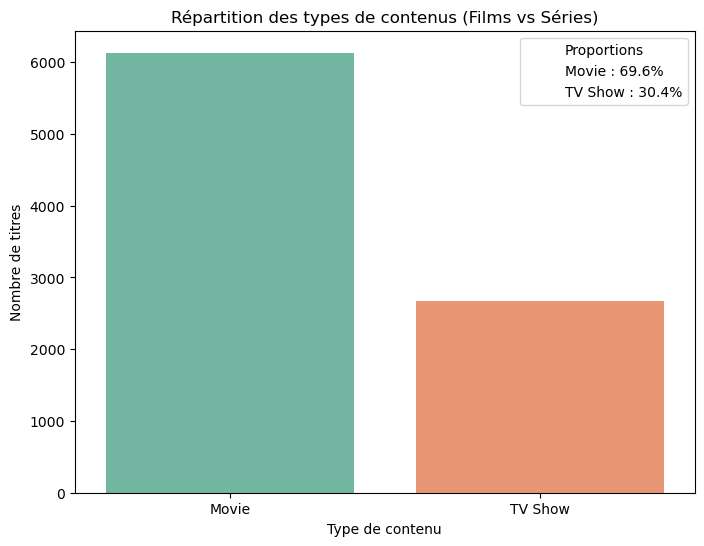

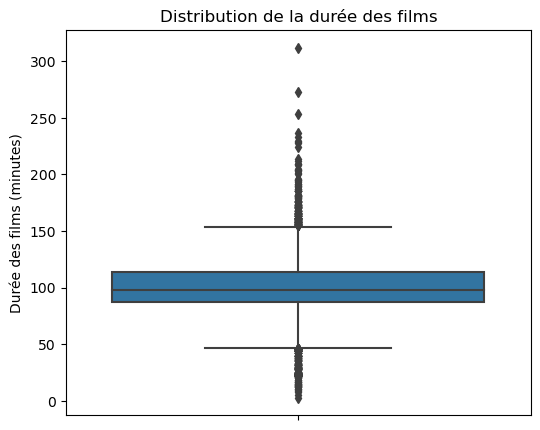

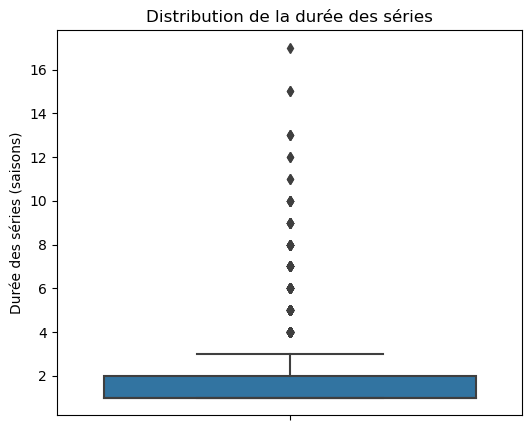

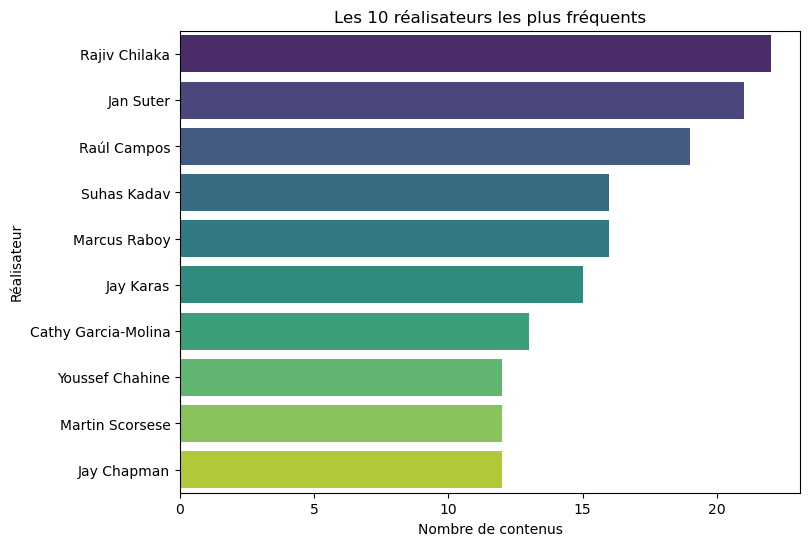

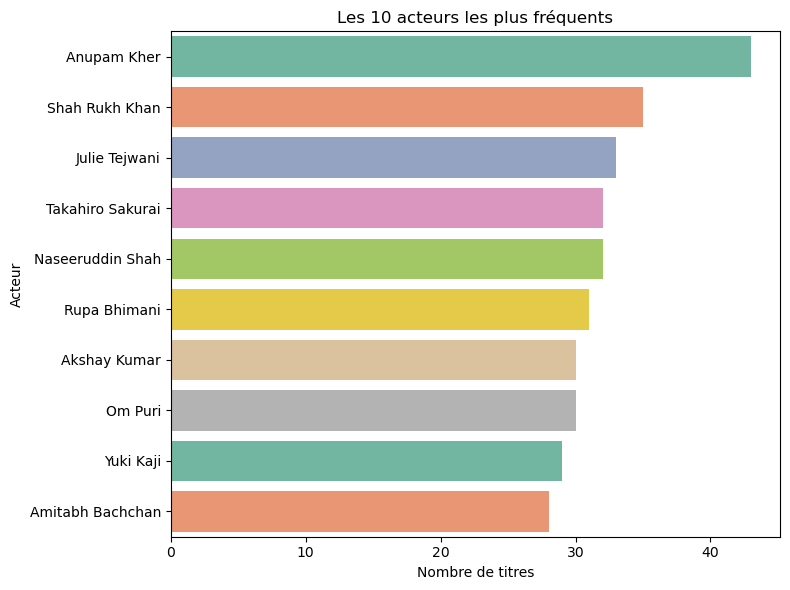


============= VISUALISATION GRAPHIQUE DES ANALYSES TEMPORELLE ================


In [23]:
print("\n============= VISUALISATION GRAPHIQUE DES ANALYSES DE CONTENU ================")
# 1- proportions du contenu: 
# 1-a : Pourcentage de presence par types 
#Countplot des types de contenus
plt.figure(figsize=(8,6))
# definir les noms des axes, separer l'axe x avec seaborn methode des mediane sur chaque countplots 
ax = sns.countplot(data=donnees, x="type", palette="Set2")
plt.title("Répartition des types de contenus (Films vs Séries)")
plt.xlabel("Type de contenu")
plt.ylabel("Nombre de titres")
# reutilisation des antecedent de 2-a) dans le calcul des pourcentages 
movie_pct = float(types_pourcentages["Movie"])
tv_pct    = float(types_pourcentages["TV Show"])
labels = [f"Movie : {movie_pct:.1f}%",f"TV Show : {tv_pct:.1f}%"]
# faire une legende avec plt pour passer nos proportions en format legende 
plt.legend(
    handles=[plt.Line2D([], [], color="none")] * 2,
    labels=labels,
    title="Proportions",
    loc="upper right",
    frameon=True
)
plt.show()
# utilisation des countplots pour faire ces graphiques 
# 1-b : pourcentage par genre 
# utulisation de px pour faire un diagramme en bande horizontale pour afficher le contenu listed_in 
genres_df = genres.reset_index()
genres_df.columns = ["genre", "valeur_numerique"]
fig = px.bar(
    genres_df,
    x="valeur_numerique",
    y="genre",
    orientation="h",
    color="genre",
    title="Répartition des genres"
)
fig.update_layout(
    height=900,              
    margin=dict(l=200),
    plot_bgcolor="gray",    
    showlegend=False,
)
fig.update_yaxes(dtick=1, automargin=True,)
fig.show()
# 1-c: boxplot de comparatif des duree moyenne et max du contenu
# pour le films 
movies = donnees[(donnees["type"] == "Movie") & donnees["duration"].notna()].copy()
movies["minutes"] = movies["duration"].str.extract(r"(\d+)").astype(int)
plt.figure(figsize=(6,5))
sns.boxplot(data=movies, y="minutes")
plt.ylabel("Durée des films (minutes)")
plt.title("Distribution de la durée des films")
plt.show()
#2 pour les series 
shows = donnees[(donnees["type"] == "TV Show") & donnees["duration"].notna()].copy()
shows["seasons"] = shows["duration"].str.extract(r"(\d+)").astype(int)
plt.figure(figsize=(6,5))
sns.boxplot(data=shows, y="seasons")
plt.ylabel("Durée des séries (saisons)")
plt.title("Distribution de la durée des séries")
plt.show()
#1- d : repartition geogrpahique 
# meme logique que repartition par genre, code reutiliser et modifié
# prendre des pays dont la distribution est superieur ou egale a 10, pour avoir un beau chart 
# la consequence a ce choix: la valeur unknow est biaise car on lui retire des valeurs numerique qui sont attribue a ces pays 
#inconus dont la distribution ne depasse pas 10. 
pays_filtre = pays[pays >= 10]   # garde seulement les valeurs ≥ 10
pays_df = pays_filtre.reset_index()
pays_df.columns = ["pays", "valeur_numerique"]
fig = px.bar(
    pays_df,
    x="valeur_numerique",
    y="pays",
    orientation="h",
    color="pays",
    title="Répartition géographique des contenus (≥ 10 titres)"
)
fig.update_layout(
    height=900,
    margin=dict(l=200),
    plot_bgcolor="gray",
    showlegend=False,
)
fig.update_yaxes(dtick=1, automargin=True)
fig.show()
#1-e : realisateur les plus frequent, 10 noms 
plt.figure(figsize=(8,6))
realisateurs_frequents.columns = ["director", "count"]
ax = sns.barplot(
    data=realisateurs_frequents,
    x="count",
    y="director",
    palette="viridis"
)
plt.title("Les 10 réalisateurs les plus fréquents")
plt.xlabel("Nombre de contenus")
plt.ylabel("Réalisateur")
plt.show()
#1-f: acteurs 
acteurs_frequents.columns = ["actor", "count"]
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=acteurs_frequents,
    x="count",
    y="actor",
    palette="Set2"
)
plt.title("Les 10 acteurs les plus fréquents")
plt.xlabel("Nombre de titres")
plt.ylabel("Acteur")
plt.tight_layout()
plt.show()
print("\n============= VISUALISATION GRAPHIQUE DES ANALYSES TEMPORELLE ================")
# comparaison des courbes de tendances des films et des series
# utilisation de l'objet go 
# types_tendances : index = release_year, colonnes = ["Movie", "TV Show"]
fig = go.Figure() # l'objet fiure go 
fig.add_trace(go.Scatter(
    x=types_tendances.index,
    y=types_tendances["Movie"],
    mode="lines+markers",
    name="Movies",
    line=dict(color="red", width=3)
)) # courbe de films 
fig.add_trace(go.Scatter(
    x=types_tendances.index,
    y=types_tendances["TV Show"],
    mode="lines+markers",
    name="TV Shows",
    line=dict(color="green", width=3, dash="dash")
)) # courbe de series
fig.update_layout(
    title="Tendance par année des dates de sortie : Films vs Séries",
    xaxis_title="Année de sortie",
    yaxis_title="Nombre de contenus",
    plot_bgcolor="black",
    paper_bgcolor="white",
    legend_title="Type de contenu"
) # modification du layout des courbes 
fig.update_xaxes(showgrid=True, gridcolor="white")
fig.update_yaxes(showgrid=True, gridcolor="white", type="linear") # modification du background 
fig.show()
# barre plot du nombre de sortie par annee de facon confondu
#utilisation de px. 
annees_sortie = donnees_temp.groupby("release_year").size().reset_index(name="nombre_de_titres")
fig = px.bar(
    annees_sortie,
    x="release_year",
    y="nombre_de_titres",
    color="nombre_de_titres",
    color_continuous_scale="Cividis",  # ou "Blues", "Plasma", etc.
)
fig.update_layout(
    title="Nombre de sortie par année, type confondu(release_date)",
    xaxis_title="Année de sortie",
    yaxis_title="Nombre de titres",
    plot_bgcolor="black",
    paper_bgcolor="white",
)
fig.show()
# graphique des ajouts de contenue sur netflix par annee/ en fonction de la periode de temps
#les mois sont pris en compte 
ajout_par_annee = (
    donnees_temp
    .groupby(donnees_temp["date_added"].dt.year)
    .size()
    .reset_index(name="nombre_de_titres")
    .rename(columns={"date_added": "annee_ajout"})
    .sort_values("annee_ajout")
)

fig = px.bar(
    ajout_par_annee,
    x="annee_ajout",
    y="nombre_de_titres",
    color="nombre_de_titres",
    color_continuous_scale="Cividis",
    title="Nombre de titres ajoutés par année",
)

fig.update_layout(
    xaxis_title="Année d'ajout",
    yaxis_title="Nombre de titres",
    plot_bgcolor="black",
    paper_bgcolor="white",
)
#graphique des dates par mois 
ajout_par_mois = (
    donnees_temp
    .groupby(donnees_temp["date_added"].dt.month)
    .size()
    .reset_index(name="nombre_de_titres")
    .rename(columns={"date_added": "mois_num"})
)
# rendre les dates en int 
ajout_par_mois["mois_num"] = ajout_par_mois["mois_num"].astype(int)
ajout_par_mois["mois"] = ajout_par_mois["mois_num"].apply(lambda m: calendar.month_name[m])
ajout_par_mois = ajout_par_mois.sort_values("mois_num")

fig = px.bar(
    ajout_par_mois,
    x="mois",
    y="nombre_de_titres",
    color="nombre_de_titres",
    color_continuous_scale="Cividis",
    title="Nombre de titres ajoutés par mois (toutes années confondues)",
)
fig.update_layout(
    xaxis_title="Mois", 
    yaxis_title="Nombre de titres",
    plot_bgcolor="black",
    paper_bgcolor="white",)
fig.show()

# ===== Tendance annuelle =====
fig_annee = px.line(
    ajout_par_annee,
    x="annee_ajout",
    y="nombre_de_titres",
    title="Tendance annuelle des ajouts",
)
fig_annee.update_traces(
    name="Ajouts annuels",         
    showlegend=True,
    line=dict(color="orange", width=3, dash="dash"),
)
fig_annee.update_layout(
    legend_title_text="Série temporelle",  
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1,
    ),
)
# ===== Tendance mensuelle =====
fig_mois = ajout_par_mois_tac.plot.line(backend="plotly")
fig_mois.update_traces(
    name="Ajouts mensuels",   # texte de légende
    line=dict(color="red", width=3, dash="solid")
)
fig_mois.update_layout(
    title="Tendance mensuelle des ajouts",
    xaxis_title="Date (mois)",
    yaxis_title="Nombre de titres",
    legend_title_text="Type de courbe",
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1,
    ),
)
fig_annee.show()
fig_mois.show()